<a href="https://colab.research.google.com/github/dinuka-rp/nerdy-panda/blob/main/Prototype/Data%20Collection/data_mining_nfts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining NFT Data

## 2.1. NFT Data Collection 

OpenSea provides different APIs for fetching NFTs data. We will be using 2 of them:
- [OpenSea Assets API](https://docs.opensea.io/reference#getting-assets)
- [OpenSea Events API](https://docs.opensea.io/reference#retrieving-asset-events)

```

### 2.1.2. Fetching Data from OpenSea APIs

We will use Python to fetch data from 2 OpenSea APIs:

* [OpenSea Assets API](https://docs.opensea.io/reference#getting-assets): We will be using this API to retrieve the following data about each NFT:

    - The Meebit's Id.
    - The creator's username and address. The creator is the person who minted the Meebit to the blockchain.
    - The owner's username and address.
    - The Meebit's traits.
    - The number of times the Meebit has been sold.

* [OpenSea Events API](https://docs.opensea.io/reference#retrieving-asset-events): We will be using this API to retrieve the following data about each Meebit’s sale transaction:

    - The Meebit's Id.
    - The seller's username and address.
    - The buyer's username and address.
    - The sale's timestamp.
    - The sale transaction's hash.
    - The price.
    - The token used for the sale.
    - The price in USD.
    - If the sale is a bundle of Meebits.

I prepared [2 python functions](https://github.com/adilmoujahid/data-mining-nfts/blob/main/helpers.py) ```parse_meebit_data(meebit_dict)``` and ```parse_sale_data(sale_dict)``` for parsing the data that we’ll fetch from the OpenSea APIs. 

Next, from a Jupyter notebook, we import the Python libaries that we'll use for the analysis.

## Mount Google Drive



In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
# from helpers import parse_meebit_data, parse_sale_data
import requests
import pandas as pd
import datetime, os
import json
import time

In [ ]:
collection_dict = {} # {collection name: total NFTs in the collection}
# collection_slug = "cryptopunks"

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('ggplot')

## Get Collection stats
to get the count of NFTs in a collection - this is needed to calculate rarity

Can get this by calling the collection stats endpoint for each asset using the collection slug.

Store this amount in an in-memory dictionary, so that the endpoint doesn't have to be called for each NFT.

In [ ]:
def get_collection_total_supply_from_stats(collection_slug):
  url = f"https://api.opensea.io/api/v1/collection/{collection_slug}/stats"

  payload={}
  headers = {
    'x-api-key': '9ef4a36cc8064a929723d5af5a3c3531',
    'Cookie': '__cf_bm=EVZwjesj4IUTDZ46LVzydsiYMUCio2BVM3leYwyewM8-1644475667-0-AdheWp/egmMJxedEP1mAp5s0WPmmEhj6fBlVUM+3RJRHlESFcsbJdv7f8/03C9Fp8jhEXmtEAPQgMhjFaqSrsPE='
  }

  response = requests.request("GET", url, headers=headers, data=payload)

  print(response.text)

  total_supply = response.json()['stats']['total_supply']

  collection_dict[collection_slug] = total_supply

  return total_supply

In [ ]:
get_collection_total_supply_from_stats(collection_slug)

In [ ]:
collection_dict[collection_slug]

In [3]:
# assets_file_path = "/content/drive/MyDrive/Datasets/FYP/bayc-nft-assets" #Bored Ape Yacht Club
# assets_file_path = "/content/drive/MyDrive/Datasets/FYP/"+ collection_slug +"-nft-assets" #by collection slugs
# assets_file_path = "/content/drive/MyDrive/Datasets/FYP/cryptokitties-nft-assets"
assets_file_path = "/content/drive/MyDrive/Datasets/FYP/collected-nft-assets"

# Helper Methods

In [ ]:
# log_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
def parse_nft_asset_data(nft_dict):

    try:
        collection_slug = nft_dict['collection']['slug']
        
        #  get Collection total supply of tokens - to calculate rarity of each NFT
        # check if the slug is available in the collection_dict first
        if collection_slug in collection_dict:
          total_supply = collection_dict[collection_slug]
        else:
          time.sleep(1)
          total_supply = get_collection_total_supply_from_stats(collection_slug)
          time.sleep(2)

    except:
        collection_slug = None

    
    nft_id = nft_dict['token_id']
    
    try:
        name = nft_dict['name']
    except:
        name = None

    try:
        asset_description = nft_dict['description']
    except:
        asset_description = None

    try:
        asset_contract_address = nft_dict['asset_contract']['address']
    except:
        asset_contract_address = None

    try:
        collection_name = nft_dict['collection']['name']
    except:
        collection_name = None
    try:
        collection_description = nft_dict['collection']['description']
    except:
        collection_description = None

    try:
        if nft_dict['collection']['safelist_request_status'] == 'verified':
          collection_verification = True
        else:
          collection_verification = False
    except:
        collection_verification = None

    try:
        creator_username = nft_dict['creator']['user']['username']
    except:
        creator_username = None
    try:
        creator_address = nft_dict['creator']['address']
    except:
        creator_address = None
    
    try:
        owner_username = nft_dict['owner']['user']['username']

    except:
        owner_username = None
    
    owner_address = nft_dict['owner']['address']
    # if (owner_address == "0x0000000000000000000000000000000000000000"):
    #   owner_address = None

    
    traits = nft_dict['traits']

    traits_string = ""

    # save total rarity in a separate column
    total_rarity = 0
    for trait in traits:
      # for each trait, extract the trait_count and calculate rarity

      if trait['trait_count'] and (total_supply) and (total_supply != 0):
        # print("trait_count:" + trait['trait_count'], "total_supply:" + total_supply)
        trait_rarity = 1/ (trait['trait_count']/total_supply)

        total_rarity += trait_rarity

      # save all trait type and values in a ;; separated string. This will have to be split into an array when loaded - for content based filtering
      # lowercase -> remove any spaces between the words before adding into the string
      trait_type = trait['trait_type'].lower()

      if isinstance(trait['value'], str):
        trait_value = trait['value'].lower()
        trait_string = trait_type + trait_value
      else:
        trait_value = trait['value']
        trait_string = trait_type + str(trait_value)

      trait_string = trait_string.replace(" ", "")
      traits_string = traits_string + trait_string + ";;"    # typevalue;;typevalue

    num_sales = int(nft_dict['num_sales'])

    # this data may be valuable for a price prediction & to identify who owned the nft before and the transacted amount - might be able to get all these from the events api itself. 
    try:
        # last_sale = nft_dict['last_sale']
        last_sale_timestamp = nft_dict['last_sale']['event_timestamp']
        last_sale_total_price = nft_dict['last_sale']['total_price']
        last_sale_from_account_address = nft_dict['last_sale']['transaction']['from_account']['address']
    except:
        # last_sale = None
        last_sale_timestamp = None
        last_sale_total_price = None
        last_sale_from_account_address = None

    try:
        top_bid = nft_dict['top_bid']
    except:
        top_bid = None


    # save img urls, can be used to make the UIs colourful & attractive
    try:
        image_url = nft_dict['image_url']
    except:
        image_url = None

    try:
        collection_image_url = nft_dict['collection']['image_url']
    except:
        collection_image_url = None

    try:
        owner_profile_img_url = nft_dict['owner']['profile_img_url']
    except:
        owner_profile_img_url = None

    try:
        creator_profile_img_url = nft_dict['creator']['profile_img_url']
    except:
        creator_profile_img_url = None

    try:
        open_sea_link = nft_dict['permalink']
    except:
        open_sea_link = None


    result = {'nft_id': nft_id,  # unique identifier in a collection/ contract?
              'name': name,
              'asset_description': asset_description,
              'asset_contract_address': asset_contract_address,
              'collection_name': collection_name,
              'collection_description': collection_description,
              'collection_slug': collection_slug,  # required to call collection related endpoints
              'collection_verification': collection_verification,
              'creator_username': creator_username,  # fancy data - address can be used to uniquely identify
              'creator_address': creator_address,
              'creator_profile_img_url': creator_profile_img_url,  # fancy data
              'owner_username': owner_username,  # fancy data - address can be used to uniquely identify
              'owner_address': owner_address,
              'owner_profile_img_url': owner_profile_img_url,  # fancy data
              'traits_string': traits_string,
              'total_rarity': total_rarity,
              'num_sales': num_sales,
              # 'last_sale': last_sale,
              'last_sale_timestamp': last_sale_timestamp,  # may be needed to normalize probable price based on other similar assets in the collection
              'last_sale_total_price': last_sale_total_price, 
              'last_sale_from_account_address': last_sale_from_account_address,
              'top_bid': top_bid,  # this seems to be useless at the moment - null is received, even though there are bids
              'open_sea_link': open_sea_link,   # fancy data - to link the website in the frontend
              'image_url': image_url,
              }
    
    return result


def parse_sale_data(sale_dict):
    
    is_bundle = False

    if sale_dict['asset'] != None:
        nft_id = sale_dict['asset']['token_id']
    elif sale_dict['asset_bundle'] != None:
        nft_id = [asset['token_id'] for asset in sale_dict['asset_bundle']['assets']]
        is_bundle = True
    
    
    seller_address = sale_dict['seller']['address']
    buyer_address = sale_dict['winner_account']['address']
    
    try:
        seller_username = sale_dict['seller']['user']['username']
    except:
        seller_username = None    
    try:
        buyer_username = sale_dict['winner_account']['user']['username']
    except:
        buyer_username = None
    
    timestamp = sale_dict['transaction']['timestamp']
    total_price = float(sale_dict['total_price']) # this is given in WEI, need to divide by 10^18 to get the value in ETH
    payment_token = sale_dict['payment_token']['symbol']
    usd_price = float(sale_dict['payment_token']['usd_price']) # this is kind of useless, since the ultimate value will be in ETH
    transaction_hash = sale_dict['transaction']['transaction_hash']
    

    result = {'is_bundle': is_bundle,
              'nft_id': nft_id,
              'seller_address': seller_address,
              'seller_username':seller_username,
              'buyer_address': buyer_address,
              'buyer_username': buyer_username,
              'timestamp': timestamp,
              'total_price': total_price, 
              'payment_token': payment_token,
              'usd_price': usd_price,
              'transaction_hash': transaction_hash}
    
    return result

# Getting NFT Assets Data

The source code below collects assets data about the 20,000 NFTs. The API has a limit of 50 items per call, and therefore we need to create a loop with 100 iterations to collect the required amount of NFT data.

## **TODO: get data from popular collections that have had transactions before**

 - new NFTs don't have much events data to offer.
 - Both data sets will be needed to show how effective the Recommendation Model is for different scenarios.

## Fetch NFT Asset Data

In [ ]:
def fetch_nft_asset_data():
  url = "https://api.opensea.io/api/v1/assets"

  for i in range(0, 300):
      offset= 50 * i

      querystring = {
          # "token_ids":"9974",
          "order_direction": "desc",
          "offset": offset,
          "limit": "50",
          # "collection": collection_slug
          }

      headers = {'x-api-key': "9ef4a36cc8064a929723d5af5a3c3531"}

      response = requests.get(url, params=querystring, headers=headers)
      
      # print(response.json()['assets'])
      if response.status_code != 200:
          print('error')
          break
      
      #Getting NFT data
      nfts = response.json()['assets']

      #Parsing NFT data
      parsed_nft_assets = [parse_nft_asset_data(nft) for nft in nfts]

      # convert json to pandas dataframe
      nft_assets_df = pd.DataFrame(parsed_nft_assets)
      # return nft_assets_df


      # save dataframe to csv & save csv to Google Drive
      nft_assets_df.to_csv(assets_file_path, mode='a', sep='\t', index=False, header=(not os.path.exists(assets_file_path)), encoding='utf-8')

      # save dataframe to json and save json to Google Drive
      #  - difficult to append. Need to read all existing data and then append
      # nft_assets_df.to_json(assets_file_path, index=False, header=(not os.path.exists(assets_file_path)), encoding='utf-8')

      # save dataframe to MongoDB


fetch_nft_asset_data()

In [ ]:
# nft_assets_df = fetch_nft_asset_data()

# nft_assets_df.info()

In [ ]:
# nft_assets_df.head()

## Read CSV - check collected NFT data

In [4]:
nft_assets_df = pd.read_csv(assets_file_path, sep='\t')

nft_assets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nft_id                          10100 non-null  object 
 1   name                            8591 non-null   object 
 2   asset_description               5918 non-null   object 
 3   asset_contract_address          10100 non-null  object 
 4   collection_name                 10100 non-null  object 
 5   collection_description          8049 non-null   object 
 6   collection_slug                 10100 non-null  object 
 7   collection_verification         10100 non-null  bool   
 8   creator_username                7741 non-null   object 
 9   creator_address                 10032 non-null  object 
 10  creator_profile_img_url         10032 non-null  object 
 11  owner_username                  9497 non-null   object 
 12  owner_address                   

In [ ]:
# remove duplicated NFTs from df

# nft_assets_df.duplicated(subset=['nft_id']).sum()

# nft_assets_df.loc[nft_assets_df.duplicated(), :]

# nft_assets_df=nft_assets_df.drop_duplicates(subset=['nft_id'], keep="first")

In [5]:
nft_assets_df.head()

,nft_id,name,asset_description,asset_contract_address,collection_name,collection_description,collection_slug,collection_verification,creator_username,creator_address,creator_profile_img_url,owner_username,owner_address,owner_profile_img_url,traits_string,total_rarity,num_sales,last_sale_timestamp,last_sale_total_price,last_sale_from_account_address,top_bid,open_sea_link,image_url
0,2541585283815458503018281017495372409420154545...,CelebCard #84 Snoop Dogg,NaN,0x495f947276749ce646f68ac8c248420045cb7b5e,Mesmerizer,No theme. No traits. No rules. A treasure trov...,mesmerizer,False,NaN,0x3830dce8b8f5543404e005776b4de22870c01d64,https://storage.googleapis.com/opensea-static/...,NullAddress,0x0000000000000000000000000000000000000000,https://storage.googleapis.com/opensea-static/...,NaN,0.0,0,NaN,NaN,NaN,NaN,https://opensea.io/assets/0x495f947276749ce646...,https://lh3.googleusercontent.com/DwknciiKsguS...
1,4460258260744616717349398633449740654585409544...,3D Penguin Planet Official Collection,3D Penguin Planet Collection It was hand paint...,0x495f947276749ce646f68ac8c248420045cb7b5e,3D Penguin Planet Official Collection,3D Penguin Planet Official Collection It was h...,3d-penguin-planet-official-collection,False,NaN,0x629c2ac970da51a3fa29af4015e06c250c267e36,https://storage.googleapis.com/opensea-static/...,NullAddress,0x0000000000000000000000000000000000000000,https://storage.googleapis.com/opensea-static/...,NaN,0.0,0,NaN,NaN,NaN,NaN,https://opensea.io/assets/0x495f947276749ce646...,https://lh3.googleusercontent.com/yzniUTh85SYY...
2,1143238369460653929904223751867794581426030911...,VECTOR KAS 10 (The Relax),VECTOR KAS 10,0x495f947276749ce646f68ac8c248420045cb7b5e,Kalvintaka Collection,NaN,kalvintaka-collection,False,Creative_FineArts_and_Designs,0xfcc0ffa7b48f9af939ed6e9d3c535e371ab2f17f,https://storage.googleapis.com/opensea-static/...,NullAddress,0x0000000000000000000000000000000000000000,https://storage.googleapis.com/opensea-static/...,NaN,0.0,0,NaN,NaN,NaN,NaN,https://opensea.io/assets/0x495f947276749ce646...,https://lh3.googleusercontent.com/2xDLW3Nrrt8u...
3,5742295951199733757787373026863398866922647154...,Gooniez #1989,"A gang of 8,888 gooniez unleashed to wreak hav...",0x495f947276749ce646f68ac8c248420045cb7b5e,Metaverse GooniezNFT,"A gang of 8,888 gooniez unleashed to wreak hav...",metaverse-goonieznft,False,GooniezNFTCollection,0x7ef43e4a20315830feacb23fe17f7cf2d49f2491,https://storage.googleapis.com/opensea-static/...,NullAddress,0x0000000000000000000000000000000000000000,https://storage.googleapis.com/opensea-static/...,NaN,0.0,0,NaN,NaN,NaN,NaN,https://opensea.io/assets/0x495f947276749ce646...,https://lh3.googleusercontent.com/Y4lDr3FzA7xm...
4,1006254684714400059060824656421626037946389019...,Darumaa Soul Story.#3,Works that are created by an Extraterrestrial ...,0x495f947276749ce646f68ac8c248420045cb7b5e,Extraterrestrial Soul Darumaa,Darumaa. Not Real & Reality.\n\nWorks that are...,darumaa,False,FRABATO,0xde77ff31b3601243b0f41441e1f015456b2b1ad2,https://storage.googleapis.com/opensea-static/...,NullAddress,0x0000000000000000000000000000000000000000,https://storage.googleapis.com/opensea-static/...,NaN,0.0,0,NaN,NaN,NaN,NaN,https://opensea.io/assets/0x495f947276749ce646...,https://lh3.googleusercontent.com/9xcm5vesaQYE...


# Analyze NFT Assets Data

In [ ]:
# number of unique names
len(nft_assets_df['creator_address'].unique())

# nft_assets_df['traits'][3]
# nft_assets_df['traits'][0]

1

Inspect data columns with no values

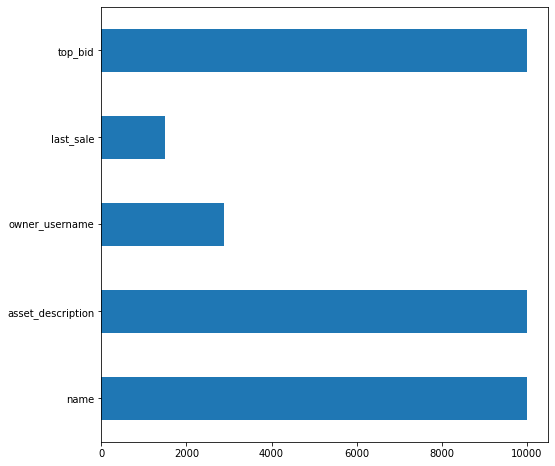

In [ ]:
data = nft_assets_df

data_null = data.isna().sum()
plt.figure(figsize=(8,8))
data_null[data_null!=0].plot(kind='barh');

In [ ]:
print(nft_assets_df.shape)

(10000, 21)


In [ ]:
txt = json.dumps(nft_assets_df.iloc[0]['last_sale'])

x = txt.strip("\"")

print(x)

{'asset': {'decimals': 0, 'token_id': '9974'}, 'asset_bundle': None, 'event_type': 'successful', 'event_timestamp': '2021-05-09T16:46:27', 'auction_type': None, 'total_price': '500000000000000000', 'payment_token': {'id': 1, 'symbol': 'ETH', 'address': '0x0000000000000000000000000000000000000000', 'image_url': 'https://storage.opensea.io/files/6f8e2979d428180222796ff4a33ab929.svg', 'name': 'Ether', 'decimals': 18, 'eth_price': '1.000000000000000', 'usd_price': '3065.059999999999945000'}, 'transaction': {'block_hash': '0xb2554b4c899a3ec7b7271d1ea84a6028eaacb0e1deed67a26048b0c0f304af27', 'block_number': '12401311', 'from_account': {'user': {'username': 'mo31985'}, 'profile_img_url': 'https://storage.googleapis.com/opensea-static/opensea-profile/15.png', 'address': '0x994cf01f34c51426bcb12bd30ff7079e280e1140', 'config': ''}, 'id': 111986825, 'timestamp': '2021-05-09T16:46:27', 'to_account': {'user': {'username': 'OpenSea-Orders'}, 'profile_img_url': 'https://storage.googleapis.com/opensea

In [ ]:
nft_assets_df.loc[nft_assets_df['nft_id'] == 0]

9999    NaN
Name: last_sale, dtype: object

In [ ]:
data.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,nft_id,name,asset_description,num_sales,top_bid
count,10000.00000,0.0,0.0,10000.000000,0.0
mean,4999.50000,NaN,NaN,2.442800,NaN
std,2886.89568,NaN,NaN,2.039349,NaN
min,0.00000,NaN,NaN,0.000000,NaN
10%,999.90000,NaN,NaN,0.000000,NaN
25%,2499.75000,NaN,NaN,1.000000,NaN
50%,4999.50000,NaN,NaN,2.000000,NaN
75%,7499.25000,NaN,NaN,3.000000,NaN
90%,8999.10000,NaN,NaN,5.000000,NaN
max,9999.00000,NaN,NaN,15.000000,NaN


In [ ]:
# data_new_stripped = data.drop([ 'name', 'asset_description', 'top_bid'],axis=1)

In [ ]:
# import seaborn as sns

# plt.figure(figsize=(25,20))
# sns.set(font_scale=1)
# sns.heatmap(data.corr(),annot=True);

## Cluster NFTs based on Trait Rarity

calculate rarity of each NFT and have a separate column for this in the dataframe

*Rarity Score for a Trait Value = 1 / ([Number of Items with that Trait Value] / [Total Number of Items in Collection])*

### Failed attempt at extracting json saved in csv

In [ ]:
result = data.iloc[0:].to_json()
parsed = json.loads(result)
json_string = json.dumps(parsed, indent=4)  

print(json_string)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
parsed[0]['traits']

'[{\'trait_type\': \'Eyes\', \'value\': \'Eyepatch\', \'display_type\': None, \'max_value\': None, \'trait_count\': 333, \'order\': None}, {\'trait_type\': \'Hat\', \'value\': "Seaman\'s Hat", \'display_type\': None, \'max_value\': None, \'trait_count\': 420, \'order\': None}, {\'trait_type\': \'Clothes\', \'value\': \'Rainbow Suspenders\', \'display_type\': None, \'max_value\': None, \'trait_count\': 135, \'order\': None}, {\'trait_type\': \'Background\', \'value\': \'Aquamarine\', \'display_type\': None, \'max_value\': None, \'trait_count\': 1266, \'order\': None}, {\'trait_type\': \'Fur\', \'value\': \'Dark Brown\', \'display_type\': None, \'max_value\': None, \'trait_count\': 1352, \'order\': None}, {\'trait_type\': \'Earring\', \'value\': \'Silver Hoop\', \'display_type\': None, \'max_value\': None, \'trait_count\': 882, \'order\': None}, {\'trait_type\': \'Mouth\', \'value\': \'Tongue Out\', \'display_type\': None, \'max_value\': None, \'trait_count\': 202, \'order\': None}]'

once saved in a CSV column/ pandas column, the array converts into a string. So, nothing will work after that.

In [ ]:
# loop through data frame
# for index, row in data.iterrows():
#   traits = row['traits']
#   print(traits)
#   # traits_string = "{'traits':" + traits + "}"
#   # traits_string = '''
#   #                 {"traits":{traits}}
#   #                 '''

#   # traits_json = json.loads(traits_string)
#   # parsed = json.loads(traits)
#   # traits_string = json.dumps(traits, indent=4)  

#   # print(traits_string)
#   # break;

#   # traits_json = json.loads(traits)

#   for trait in traits:
#     print(trait)
#     trait_string = json.dumps(trait, indent=4)  
#     print(trait_string)
#     break;
#   break

    # print(row['nft_id'], row['traits'])
# calculate rarity for each trait

# add all rarity counts and calculate total rarity for each NFT


[{'trait_type': 'Eyes', 'value': 'Eyepatch', 'display_type': None, 'max_value': None, 'trait_count': 333, 'order': None}, {'trait_type': 'Hat', 'value': "Seaman's Hat", 'display_type': None, 'max_value': None, 'trait_count': 420, 'order': None}, {'trait_type': 'Clothes', 'value': 'Rainbow Suspenders', 'display_type': None, 'max_value': None, 'trait_count': 135, 'order': None}, {'trait_type': 'Background', 'value': 'Aquamarine', 'display_type': None, 'max_value': None, 'trait_count': 1266, 'order': None}, {'trait_type': 'Fur', 'value': 'Dark Brown', 'display_type': None, 'max_value': None, 'trait_count': 1352, 'order': None}, {'trait_type': 'Earring', 'value': 'Silver Hoop', 'display_type': None, 'max_value': None, 'trait_count': 882, 'order': None}, {'trait_type': 'Mouth', 'value': 'Tongue Out', 'display_type': None, 'max_value': None, 'trait_count': 202, 'order': None}]
[
"["


In [ ]:
import ast
import numpy as np
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


df2 = pd.read_csv(assets_file_path, converters={'traits': from_np_array})
print(df2)

## Clean Asset Data

*   Remove NFTs that have no text that can be worked with at all (descriptions/ sensible names - nouns, non-stop words,etc.) - can have this check when parsing as well (check later)


# Getting NFT sales transactions data

The source code below collects all sale transactions data. The API has a limit of 50 items per call, and therefore we need to create a loop to collect all sale transactions data.

https://docs.cryptosheets.com/providers/opensea/retrieving-events/

Assets and events will most likely match only in NFTs from collections - that have had a few transactions.

Otherwise, events data can be used only to train a price prediction algorithm.

In [ ]:
sales_file_path = "/content/drive/MyDrive/Datasets/FYP/bayc-nft-sales"
# sales_file_path = "/content/drive/MyDrive/Datasets/FYP/collected-nft-sales"

In [ ]:
requested_token_ids = []

In [ ]:
for index, row in nft_sales_df.iterrows():
  if row['nft_id'] not in requested_token_ids:
    requested_token_ids.append(row['nft_id'])
    print(row['nft_id'])

In [ ]:
requested_token_ids

request for events only if assets information has 

In [ ]:
url = "https://api.opensea.io/api/v1/events"

#  fetch events for each nft in the list (0-9999 in BAYC)

for i in range(0, 500):
      offset= 50 * i

    # if not (i in requested_token_ids):
      
      # query events for each nft asset
      querystring = {
          "token_id": i,
          "event_type":"successful",
          "only_opensea":"true",
          "offset":0,
          "limit":"50",
          "collection_slug": collection_slug,
          "asset_contract_address": "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d",
          }

      headers = {"Accept": "application/json", 'x-api-key': "9ef4a36cc8064a929723d5af5a3c3531"}

      response = requests.request("GET", url, headers=headers, params=querystring)

      rh
      print(i)
      if response.status_code != 200:
          print(response)
          print('error')
          time.sleep(6)
          continue
      
      #Getting meebits sales data
      nft_sales = response.json()['asset_events']

      if nft_sales == []:
          print(response)
          # break
          continue
      
      #Parsing meebits sales data
      parsed_nft_sales = [parse_sale_data(sale) for sale in nft_sales]

      # convert json to pandas dataframe
      nft_sales_df = pd.DataFrame(parsed_nft_sales)

    # save dataframe to a separate csv & save csv to Google Drive
      nft_sales_df.to_csv(sales_file_path, mode='a', sep='\t', index=False, header=(not os.path.exists(sales_file_path)), encoding='utf-8')

# this token_id addition isn't working as expected
      # requested_token_ids.append(sale['asset']['token_id'] for sale in nft_sales)

# print(sale['asset']['token_id'] for sale in nft_sales)

    # else:
    #   continue

NameError: ignored

In [ ]:
nft_sales_df = pd.read_csv(sales_file_path, sep='\t')

nft_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_bundle         256 non-null    bool   
 1   nft_id            256 non-null    int64  
 2   seller_address    256 non-null    object 
 3   seller_username   232 non-null    object 
 4   buyer_address     256 non-null    object 
 5   buyer_username    214 non-null    object 
 6   timestamp         256 non-null    object 
 7   total_price       256 non-null    float64
 8   payment_token     256 non-null    object 
 9   usd_price         256 non-null    float64
 10  transaction_hash  256 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 20.4+ KB


In [ ]:
nft_sales_df["nft_id"].value_counts()

76      7
99      6
75      6
67      6
78      6
       ..
5552    1
8647    1
378     1
1074    1
35      1
Name: nft_id, Length: 130, dtype: int64

In [ ]:
nft_sales_df.head()

,is_bundle,nft_id,seller_address,seller_username,buyer_address,buyer_username,timestamp,total_price,payment_token,usd_price,transaction_hash
0,False,2221,0x47d4f20ae83bcd350105f199f900e6e6104dab6a,doh,0xe92ff0f4daf94a110cbd36c98a8e50662d8779e8,LizH,2022-02-12T06:25:42,9.800000e+19,ETH,2936.00,0x55a18cb12038b1222a2417911ab3cbe57b7e1569be1e...
1,False,4237,0x2779b18802900aa795bd284f4aa10777b1109ba4,ArtBlocksFanatic,0x7eb413211a9de1cd2fe8b8bb6055636c43f7d206,NaN,2022-02-12T05:43:10,1.110000e+20,WETH,2929.28,0x199d66227a45e82309b945c410895b4ce51ace6400eb...
2,False,1964,0x682306c109b41db56b4fdea915429ba4cc263321,NaN,0x500f2e800003f7f33e1edc76e3ae89b591f432a6,cryptocoiners,2022-02-12T04:42:14,9.569000e+19,ETH,2936.00,0xc375d63e656afd6ebee82a73b87606c5a8fba994dc2e...
3,False,6233,0xe3e009c63ee00d20f5ceeccf34df1dc08d68b5cf,BlueMagicBCRC,0x2edfa738dfcc3182c79646ea263b42f5734d914b,NaN,2022-02-12T04:31:11,9.500000e+19,ETH,2936.00,0x24ddfb741daa11fc1e6e5fec5ffef8489a121a099317...
4,False,3046,0xed47015bb8080b9399f9d0ddfc427b9cee2caab1,0xed4701,0x7eb413211a9de1cd2fe8b8bb6055636c43f7d206,NaN,2022-02-12T01:41:59,2.270000e+20,WETH,2929.28,0x502a190c0b1265375ce5665386700c2ae1ddd723419e...


If the same transaction hash is found multiple times, remove them.

This is to omit a fault in the API - sometimes it will return whatever it can if events aren't available for a specific token (no sales have happened)

# 2.2. Analyzing Meebits Data and Meebits Sale Transactions

Now that we have the data in MongoDB, we can start analyzing it. 

### 2.2.1. Reading the Data
We start by reading both the assets data and the transactions data into 2 Pandas DataFrames.

In [ ]:
meebits = meebits_collection.find()
meebits_df = pd.DataFrame(meebits)

meebit_sales = sales_collection.find()
meebit_sales_df = pd.DataFrame(meebit_sales)

In [ ]:
print("The database has information about %d Meebits." % len(meebits_df))
print("The database has information about %d Meebits sale transactions." % len(meebit_sales_df))

### 2.2.2. Getting Top 10 Meebits Creators

In [ ]:
creators = []
for creator_address in meebits_df['creator_address'].value_counts().index[:10]:
    creator_data = {}
    creator_data['creator_address'] = creator_address
    creator_data['creator_username'] = meebits_df[meebits_df['creator_address'] == creator_address]['creator_username'].iloc[0]
    creator_data['number_meebits'] = len(meebits_df[meebits_df['creator_address'] == creator_address])
    creators.append(creator_data)

pd.DataFrame(creators)

In [ ]:
#### Getting total number of Meebit Creators and Owners.
print("There are %d unique Meebit creators." % len(meebits_df['creator_address'].unique()))
print("There are %d unique Meebit owners." % len(meebits_df['owner_address'].unique()))

### 2.2.3. Getting Stats about Bundle/Single Sales and Types of Payment

In [ ]:
meebit_sales_df['is_bundle'].value_counts()

In [ ]:
meebit_sales_df[meebit_sales_df['is_bundle'] == False]['payment_token'].value_counts()

### 2.2.4. Filering Sale Transactions and Adding New Features

To make the analysis easier, we will only focus on single sales done in ETH or WETH.

In [ ]:
meebit_sales_df = meebit_sales_df[(meebit_sales_df['payment_token'] != 'USDC') & (meebit_sales_df['is_bundle'] == False)].copy()

Next, we do some data cleaning and we add a new feature

In [ ]:
# Parsing dates
meebit_sales_df['timestamp'] = pd.to_datetime(meebit_sales_df['timestamp'])
# Converting sales price from WEI to ETH
meebit_sales_df['total_price'] = meebit_sales_df['total_price']/10.**18
# Calculating the sale prices in USD
meebit_sales_df['total_price_usd'] = meebit_sales_df['total_price'] * meebit_sales_df['usd_price']

### 2.2.5. Meebits Sales Timelines

#### Total Number of Sales per Day

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').count()['total_price']
ax = data.plot.bar(figsize=(18, 6))

ax.set_alpha(0.8)
ax.set_title("Number of Meebits Sales per Day", fontsize=18)
ax.set_ylabel("Number of Meebits Sales", fontsize=18)

#https://github.com/pandas-dev/pandas/issues/1918
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(data.index.to_series().dt.strftime("%d %b %Y")))

#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+40, \
            str(round((i.get_height()), 2)), fontsize=11, color='dimgrey',
                rotation=45)

#### Total Sales per Day in ETH

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').sum()['total_price']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Total Meebit Sales in ETH", fontsize=18)
ax.set_ylabel("Sales in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.0f}".format(j), xy=(i, j+200), rotation=45)

#### Total Sales per day in USD

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price_usd']].resample('D', on='timestamp').sum()['total_price_usd']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Total Meebit Sales in Million USD", fontsize=18)
ax.set_ylabel("Sales in Million USD", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.2f}".format(j/10.**6), xy=(i, j), rotation=45)

### 2.2.6. Meebits Prices Timelines 

#### Average Meebit Price per Day in ETH 

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').mean()['total_price']
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Average Meebit Price in ETH", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18);
#ax.annotate(s='sdsdsds', xy=(1, 1))

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.2f}".format(j), xy=(i, j+.2), rotation=45)

#### Floor Meebit Price per Day in ETH

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').min()['total_price']
ax = data.plot(figsize=(18,6), color="orange", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Floor Meebit Price in ETH", fontsize=18)
ax.set_ylabel("Floor Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for d, v in zip(dates, values):
    ax.annotate(s="{:.2f}".format(v), xy=(d, v), rotation=45)

#### Max Meebit Price per Day in ETH

In [ ]:
data = meebit_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').max()['total_price']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Max Meebit Price in ETH", fontsize=18)
ax.set_ylabel("Max Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.0f}".format(j), xy=(i, j+30), rotation=45)

### 2.2.6. Analyzing Meebits' Sellers and Buyers

In [ ]:
print("There are %d unique Meebit sellers." % len(meebit_sales_df['seller_address'].unique()))
print("There are %d unique Meebit buyers." % len(meebit_sales_df['buyer_address'].unique()))

#### Getting Top 10 Meebits Buyers

In [ ]:
buyers = []
for buyer_address in meebit_sales_df['buyer_address'].value_counts().index[:10]:
    buyer_data = {}
    buyer_data['buyer_address'] = buyer_address
    buyer_data['buyer_username'] = meebit_sales_df[meebit_sales_df['buyer_address'] == buyer_address]['buyer_username'].iloc[0]
    buyer_data['number_buys'] = len(meebit_sales_df[meebit_sales_df['buyer_address'] == buyer_address])
    buyer_data['min_price'] = meebit_sales_df[meebit_sales_df['buyer_address'] == buyer_address]['total_price'].min()
    buyer_data['max_price'] = meebit_sales_df[meebit_sales_df['buyer_address'] == buyer_address]['total_price'].max()
    buyer_data['mean_price'] = meebit_sales_df[meebit_sales_df['buyer_address'] == buyer_address]['total_price'].mean()
    buyers.append(buyer_data)
    
pd.DataFrame(buyers)

#### Getting Top 10 Meebits Sellers

In [ ]:
sellers = []
for seller_address in meebit_sales_df['seller_address'].value_counts().index[:10]:
    seller_data = {}
    seller_data['seller_address'] = seller_address
    seller_data['seller_username'] = meebit_sales_df[meebit_sales_df['seller_address'] == seller_address]['seller_username'].iloc[0]
    seller_data['number_sales'] = len(meebit_sales_df[meebit_sales_df['seller_address'] == seller_address])
    seller_data['min_price'] = meebit_sales_df[meebit_sales_df['seller_address'] == seller_address]['total_price'].min()
    seller_data['max_price'] = meebit_sales_df[meebit_sales_df['seller_address'] == seller_address]['total_price'].max()
    seller_data['mean_price'] = meebit_sales_df[meebit_sales_df['seller_address'] == seller_address]['total_price'].mean()
    sellers.append(seller_data)
    
pd.DataFrame(sellers)

#### Intersection of Top 10 Buyers and Top 10 sellers

In [ ]:
top_10_buyers = meebit_sales_df['buyer_address'].value_counts().index[:10]
top_10_sellers = meebit_sales_df['seller_address'].value_counts().index[:10]
print(list(set(top_10_buyers) & set(top_10_sellers)))

#### Getting Number of Sales between same Buyers and Sellers 

In [ ]:
(meebit_sales_df['seller_address'] + meebit_sales_df['buyer_address']).value_counts().value_counts()